### Importing Relevant Packages

In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
sns.set()

### Loading and Transforming the Data

In [25]:
raw_csv_data = pd.read_csv("data/Index2018.csv")
df_comp = raw_csv_data.copy()
df_comp.date = pd.to_datetime(df_comp.date, format = "%d/%m/%Y")
df_comp.set_index("date",inplace = True)
df_comp = df_comp.asfreq('b')
df_comp = df_comp.fillna(method='ffill')

### Removing Surplus Data

In [26]:
df_comp['market_value'] = df_comp.spx
del df_comp['spx'],df_comp['dax'],df_comp['ftse'],df_comp['nikkei']
size = int(len(df_comp) * 0.8)
df,df_test = df_comp.iloc[:size],df_comp.iloc[size:]


### White Noise


White Noise is a time series, where every time point has a random value associated with it. There is no relationship between the past and present data, and, as a result, the future values cannot be predicted using past data. For a predictable time series, there has to be some relationship between the past and the future data, and the absence of such a relationship makes it impossible to predict future data using the past data. 

Mathematically, White Noise satisfiles the following 3 properties. 

* 1) Constant Mean. 
* 2) Constant Variance. 
* 3) No autocorrelation between any period.

Autocorrelation measures how correlated a series is with past versions of itself. 
No Autocorrelation means there is no clear relationship between past and present values.

In [27]:
wn = np.random.normal(loc = df.market_value.mean(), scale = df.market_value.std(), size = len(df))
df['wn'] = wn

C:\Users\Admin\AppData\Local\Temp/ipykernel_2676/2468947593.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['wn'] = wn


In [28]:
df.describe()

,market_value,wn
count,5021.000000,5021.000000
mean,1091.651926,1090.799547
std,292.559287,290.816271
min,438.920000,-26.057863
25%,914.620000,891.410226
50%,1144.650000,1092.249817
75%,1316.280729,1286.147478
max,1570.252238,2259.130923


Note - The mean of the white noise is not exactly equal to the mean of the market_value. THis is due to the fact that the values are randomly drawn from the distribution that has the same mean as market_value. However, the individual points are randomly drawn and their mean may slightly differ from that of the distribution.

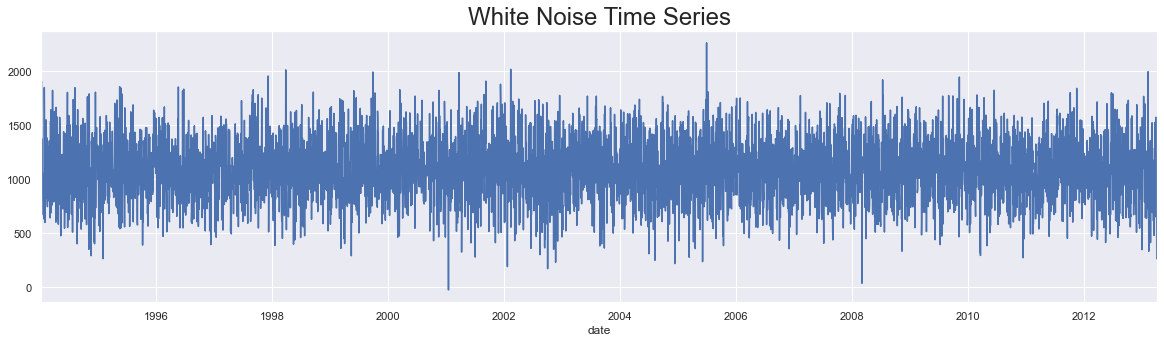

In [29]:
df.wn.plot(figsize=(20,5))
plt.title('White Noise Time Series',size = 24)
plt.show()

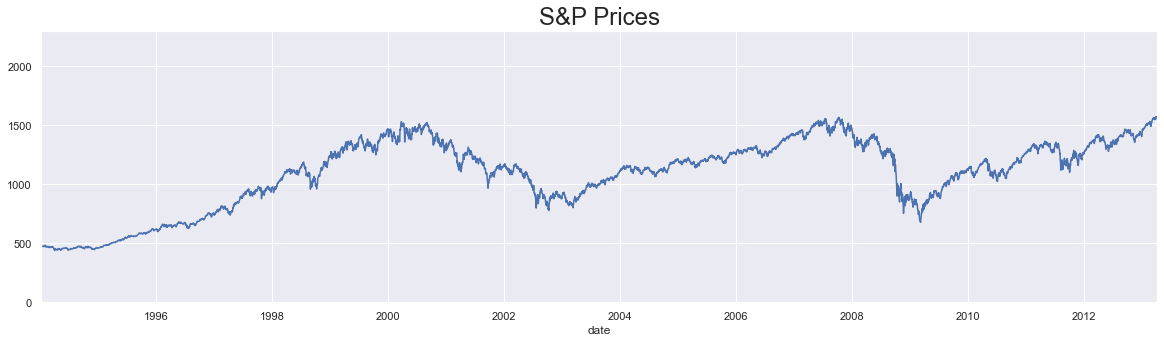

In [31]:
df.market_value.plot(figsize=(20,5))
plt.title('S&P Prices',size = 24)
plt.ylim(0,2300)
plt.show()


### Comparison of the Plots

Comparing the graph of the White Noise with S&P prices, one can conclude that the S&P prices are far less random than the white noise. Lack of Randomness indicates presence of a pattern. Our goal will be to identify this pattern and use it to predict future values.


### Random Walk

A special type of time-series, where values tend to persist over time and the difference between consecutive periods is white noise.

If we consider S&P price a random walk, it would imply that the peice on a particular day will be the sum of the price on the previous day and a number randomly drawn from the white noise distribution.

In [35]:
rw = pd.read_csv('data/Randomwalk.csv')
rw.date = pd.to_datetime(rw.date,format="%d/%m/%Y")
rw.set_index("date",inplace=True)
rw = rw.asfreq('b')

In [37]:
rw.describe()

,price
count,5021.000000
mean,1269.944293
std,444.216793
min,585.483034
25%,931.550429
50%,1156.363045
75%,1488.362029
max,2715.508720


In [38]:
df['rw'] = rw.price

C:\Users\Admin\AppData\Local\Temp/ipykernel_2676/818302766.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['rw'] = rw.price


In [39]:
df.head()

,market_value,wn,rw
date,,,
1994-01-07,469.90,1533.640537,1122.139662
1994-01-10,475.27,1903.078869,1080.347860
1994-01-11,474.13,667.831764,1082.095245
1994-01-12,474.17,877.651214,1083.639265
1994-01-13,472.47,1369.006338,1067.146255


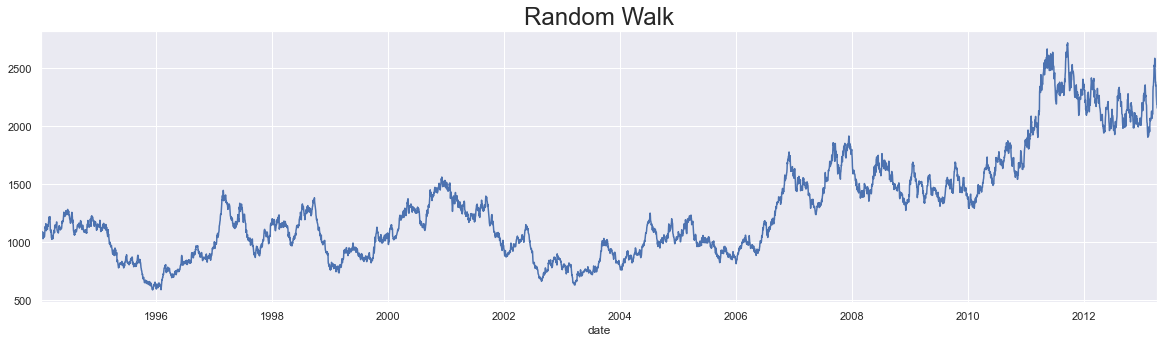

In [42]:
df.rw.plot(figsize=(20,5))
plt.title('Random Walk',size = 24)
plt.show()

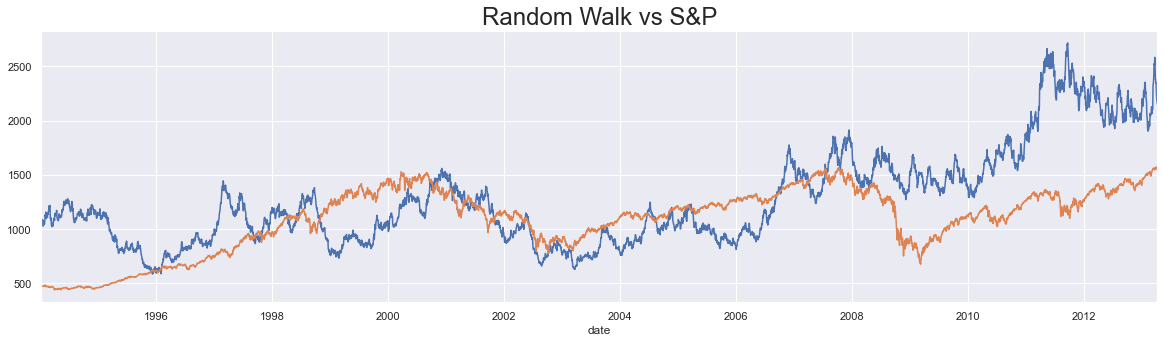

In [43]:
df.rw.plot(figsize=(20,5))
df.market_value.plot(figsize=(20,5))
plt.title('Random Walk vs S&P',size = 24)
plt.show()

#### Note the similarity in nature of the two plots 
* 1) Small variation between consecutive time periods.
* 2) The cyclical nature of plots over a short period of time.

### Stationarity

##### Weak Stationarity 

Any two sample windows same length of time apart should have the same covariance. 

Eg. Cov(T1,T4) (the covariance of time window starting at T1 and the window starting at T4) should be same as the Cov(T5,T8) (the windows starting at T5 and T8) because in both cases the windows are 3 ime units apart.

Or, Cov(T,T+L) is same for all T = t1,t2,t3...

Essentially 3 conditions must be satisfied. 

* 1) Constant Mean.
* 2) Constant Variance.
* 3) Constant Covariance between contiguous samples that are same lenght apart.

This also implies that Cov(T,T+L) is dependent only on L, not on T.

##### Strong Stationarity 

Strong stationarity requires that the distributions of the series starting at T and the series starting at T+L be identical for all T.

##### Dickey Fuller test for stationarity

Null Hypothesis -> Time Series is not stationary. -> Lag 1 autocorrelation is < 1.
Alternate Hypothesis -> Time series is stationary. -> Lag 1 autocorrelation is = 1.

Compute the test statistic. If the test statistic < crtitical value, reject the null hypothesis. Time series is stationary.


Later on augmented Dicket Fuller test was designed to augment for time dependency in the data.


In [46]:
sts.adfuller(df.market_value)

(-1.7369847452352445,
 0.4121645696770618,
 18,
 5002,
 {'1%': -3.431658008603046,
  '5%': -2.862117998412982,
  '10%': -2.567077669247375},
 39904.880607487445)

The first number here is the test statistic. We also see the critical values at 3 levels of significance. Here, the test statistic is higher than critical values for all three significance levels, so we are unable to reject the null hypothesis.

The second number here(0.412) is the p value, the chance of not rejecting the null.

18 - Number of lags used in regression when determining the t-statistic.  Not sure what this is about. How is this decided? Need to find out more later.

5002 - the number of observations used in the series.

18 + 5002 should be the number of data points in the series.

39904 - the maximum information criterion. Need to check.


In [47]:
sts.adfuller(df.wn)

(-37.80203037730758,
 0.0,
 3,
 5017,
 {'1%': -3.431654095870046,
  '5%': -2.8621162697870046,
  '10%': -2.5670767490325597},
 70731.7279864583)

As expected, we see that white noise is most definitiely stationary.